# EU Energy Consumption by Major Energy Source Analysis (1990-2023)

## 1. Introduction



This project uses openly available energy statistics database from [Eurostat](https://ec.europa.eu/eurostat/), which provides comprehensive and harmonized data on energy production, consumption, and trade across EU member states. Energy source consumption data for energy use and non-energy use is extracted for each major fuel type from 1990 to the most recent available year (2024, provisional). Four major fuel categories are analysed:

- **Oil and petroleum products**: include crude oil and petroleum derivatives such as gasoline, diesel, kerosene, fuel oil, heating oil, bitumen and other oil-based products. Crude oil is a naturally occurring liquid fossil fuel extracted from underground reservoirs and refined into various petroleum products for transportation, heating, and industrial use.
- **Solid fossil fuels**: include coal (hard coal, lignite), peat, and coke. These are carbon-rich energy sources formed from ancient plant material over millions of years, primarily used for electricity generation and industrial processes.
- **Natural gas**: a fossil fuel composed mainly of methane, used for heating, electricity generation, and as an industrial feedstock. It is not solid like coal or liquid like oil, but exists in a gaseous state at room temperature and pressure.
- **Renewable energy sources**: non-fossil energy sources that are naturally replenished, including wind, hydro, solar,geothermal, biomass, and biogases. These sources have a much lower environmental impact compared to fossil fuels and are key to the energy transition towards sustainability.

These categories represent distinct fuel types with different end uses and environmental impacts, allowing meaningful comparison of long-term energy consumption trends and the ongoing energy transition. All datasets contain annual data, expressed in thousands of tonnes of oil equivalent (KTOE). Each dataset contains country-level annual observations, along with detailed metadata describing energy usage categories, measurement units, and reporting flags.

The raw Eurostat datasets were first imported as raw tabular data and subsequently cleaned and aggregated to produce a consistent, normalized database suitable for storage and reuse. Subsequently, for analytical and visualisation purposes, additional data quality checks were performed on pivoted datasets to identify years with insufficient country coverage. Provisional years with high proportions of missing data (such as 2024) were excluded from the analysis to avoid bias in visualisation and forecasting results.

How has fossil fuel usage changed over time?

Is gas replacing solid fuels?

Are renewables increasing relative to oil?

## 2. Data Preparation

### 2.1 Initial Data Cleaning and Aggregation

Raw data for each fuel type was imported from the Eurostat API as CSV files into Pandas DataFrames. 

In [2]:
# Pandas is the primary library for data manipulation and analysis
import pandas as pd
# Matplotlib is used for data visualization
import matplotlib.pyplot as plt
# Seaborn is used for enhanced statistical data visualization
import seaborn as sns
# MySQL connector for database interaction
import mysql.connector
# Import os for environment variable management
import os
# Geopandas for geospatial data handling
import geopandas as gpd
#
import numpy as np
from dask.order import order
#
from sklearn.linear_model import LinearRegression
#
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Import data from Eurostat API for oil and petroleum derivatives consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=O4000XBIO,O4651,O4652XR5210B,O4653,O4661XR5230B,O4671XR5220B,O4695&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
oil_and_petroleum_df = pd.read_csv(url)
oil_and_petroleum_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1990,NaN,891.783,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1991,NaN,561.706,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1992,NaN,416.136,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1993,NaN,380.111,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,O4000XBIO,Oil and petroleum products (excluding biofuel ...,KTOE,...,AL,Albania,1994,NaN,464.489,NaN,NaN,NaN,NaN,NaN


In [4]:
# Import data from Eurostat API for solid fossil fuels consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=C0000X0350-0370,C0110,C0121,C0129,C0220,C0311,C0312,C0350,P1000,P1100,O4694&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
solid_fossil_fuels_df = pd.read_csv(url, low_memory= False)
solid_fossil_fuels_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1990,NaN,571.289,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1991,NaN,328.198,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1992,NaN,91.786,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1993,NaN,45.188,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,C0000X0350-0370,Solid fossil fuels,KTOE,...,AL,Albania,1994,NaN,39.511,NaN,NaN,NaN,NaN,NaN


In [5]:
# Import data from Eurostat API for natural gas
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=G3000&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
natural_gas_df = pd.read_csv(url)
natural_gas_df.head()


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1990,NaN,203.203,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1991,NaN,118.229,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1992,NaN,85.641,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1993,NaN,68.444,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,G3000,Natural gas,KTOE,...,AL,Albania,1994,NaN,43.573,NaN,NaN,NaN,NaN,NaN


In [6]:
# Import data from Eurostat API for renewables consumption
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/nrg_bal_c/1.0/*.*.*.*.*?c[freq]=A&c[nrg_bal]=GAE,NRGSUP,PEC2020-2030,FEC2020-2030,AFC,FC_NE,FC_E&c[siec]=RA000,RA100,RA200,RA300,RA410,RA420,RA500,R5110-5150_W6000RI,R5210P,R5220P&c[unit]=KTOE&c[geo]=BE,BG,CZ,DK,DE,EE,IE,EL,ES,FR,HR,IT,CY,LV,LT,LU,HU,MT,NL,AT,PL,PT,RO,SI,SK,FI,SE,IS,NO,UK,BA,ME,MD,MK,GE,AL,RS,TR,UA,XK&c[TIME_PERIOD]=2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990&compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name'
renewables_df = pd.read_csv(url)
renewables_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,nrg_bal,Energy balance,siec,Standard international energy product classification (SIEC),unit,...,geo,Geopolitical entity (reporting),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag) V2 structure,CONF_STATUS,Confidentiality status (flag)
0,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1990,NaN,363.022,NaN,NaN,NaN,NaN,NaN
1,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1991,NaN,363.022,NaN,NaN,NaN,NaN,NaN
2,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1992,NaN,363.022,NaN,NaN,NaN,NaN,NaN
3,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1993,NaN,346.494,NaN,NaN,NaN,NaN,NaN
4,dataflow,ESTAT:NRG_BAL_C(1.0),Complete energy balances,A,Annual,AFC,Available for final consumption,R5110-5150_W6000RI,Primary solid biofuels,KTOE,...,AL,Albania,1994,NaN,330.730,NaN,NaN,NaN,NaN,NaN


Each dataset contained extensive metadata and multiple entries per country per year, broken down by various usage categories (e.g., energy use, non-energy use, final consumption, etc.). To facilitate analysis, the data needed to be cleaned and aggregated to have one row per country per year, with consumption summed across all usage categories. The irrelevant columns were dropped, the remaining columns were renamed for clarity, and data types were converted as needed. Each cleaned dataset was augmented with a new column indicating the fuel type. This cleaning process was applied to each of the four datasets and produced a tidy, normalized format suitable for analysis and visualization. This has been achieved using the ` clean_and_aggregate()` function defined below.

In [7]:
def clean_and_aggregate(df, fuel = ""):
    """
    Cleans a Eurostat energy dataset and aggregates it so that:
    - One row per country per year
    - Consumption summed across all usage categories

    Returns:
    --------
    pd.DataFrame
        Cleaned, aggregated dataframe
    """

    # 1. Drop unnecessary columns
    columns_to_drop = [
        'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'freq', 'Time frequency',
        'nrg_bal', 'Energy balance', 'siec',
        'Standard international energy product classification (SIEC)',
        'Unit of measure', 'unit', 'geo', 'Time', 'Observation value',
        'OBS_FLAG', 'Observation status (Flag) V2 structure',
        'CONF_STATUS', 'Confidentiality status (flag)'
    ]

    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # 2. Rename columns
    df = df.rename(columns={
        'TIME_PERIOD': 'Year',
        'Geopolitical entity (reporting)': 'Country',
        'OBS_VALUE': 'Consumption_KTOE'
    })

    # 3. Convert year to int
    df['Year'] = df['Year'].astype(int)

    # 4. Ensure numeric consumption
    df['Consumption_KTOE'] = pd.to_numeric(df['Consumption_KTOE'], errors='coerce')

    # 5. Drop missing or invalid consumption values
    df = df.dropna(subset=['Consumption_KTOE'])

    # 6. Aggregate by Country and Year across all usage categories to produce one observation per country per year
    df = (
        df.groupby(['Country', 'Year'], as_index=False)
          .agg({'Consumption_KTOE': 'sum'})
    )

    # 7. Add a new column indicating the fuel type
    df['fuel_type'] = fuel

    return df


In [8]:
oil_petrol_clean = clean_and_aggregate(oil_and_petroleum_df, 'Oil & Petroleum')
oil_petrol_clean.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4884.643,Oil & Petroleum
1,Albania,1991,3349.616,Oil & Petroleum
2,Albania,1992,2540.534,Oil & Petroleum
3,Albania,1993,2469.427,Oil & Petroleum
4,Albania,1994,3099.698,Oil & Petroleum


In [9]:
solid_fossil_fuels_clean = clean_and_aggregate(solid_fossil_fuels_df, 'Solid Fossil Fuels' )
solid_fossil_fuels_clean.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4744.548,Solid Fossil Fuels
1,Albania,1991,2848.038,Solid Fossil Fuels
2,Albania,1992,821.954,Solid Fossil Fuels
3,Albania,1993,481.800,Solid Fossil Fuels
4,Albania,1994,428.130,Solid Fossil Fuels


In [10]:
natural_gas_clean = clean_and_aggregate(natural_gas_df, 'Natural Gas')
natural_gas_clean.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,812.812,Natural Gas
1,Albania,1991,472.916,Natural Gas
2,Albania,1992,342.564,Natural Gas
3,Albania,1993,273.776,Natural Gas
4,Albania,1994,174.292,Natural Gas


In [11]:
renewables_clean = clean_and_aggregate(renewables_df, 'Renewables')
renewables_clean.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,3883.712,Renewables
1,Albania,1991,4114.150,Renewables
2,Albania,1992,4013.720,Renewables
3,Albania,1993,3911.762,Renewables
4,Albania,1994,3942.832,Renewables


The result of this step is a clean, normalized dataset for each fuel type, where energy consumption is expressed in kilotonnes of oil equivalent (KTOE) and duplicated records are eliminated. This level of cleaning ensures the data is structurally consistent while preserving all factual observations.

### 2.2 Storage of Cleaned Data in a MySQL Database

Following the initial cleaning and aggregation, the datasets were stored in a MySQL relational database to enable structured storage and reproducibility. MySQL Workbench has been installed to manage the database. MySQL connector for Python has been installed in the environment using `pip install mysql-connector-python`.  A database table schema named `energy_consumption` was created with columns representing country, year, fuel type, and energy consumption, using the following SQL command:
```sql
CREATE TABLE energy_consumption (
    id INT AUTO_INCREMENT PRIMARY KEY,
    country VARCHAR(100),
    year INT,
    fuel_type VARCHAR(50),
    consumption_ktoe DOUBLE
);
```

In [12]:
# Combine all cleaned dataframes into one for insertion
all_energy = pd.concat(
    [oil_petrol_clean, natural_gas_clean, solid_fossil_fuels_clean, renewables_clean],
    ignore_index=True
)


A connection to the MySQL database was subsequently established using the `mysql.connector` library. Database credentials were not hard-coded in the source code. Instead, environment variables were used to securely manage authentication details, following best security practices.

In [13]:
# Establish MySQL database connection
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password=os.getenv("MYSQL_PASSWORD"),
    database="energy_data"
)

cursor = conn.cursor()


The cleaned datasets for each fuel type were inserted into the `energy_consumption` table using parameterized SQL queries to prevent SQL injection attacks. The first 10 rows of the inserted data were queried and printed to verify successful insertion.

In [14]:
# Insert data into MySQL database
insert_query = """
INSERT INTO energy_consumption (country, year, fuel_type, consumption_ktoe)
VALUES (%s, %s, %s, %s) # Parameterized query to prevent SQL injection
"""

data_to_insert = [
    (row.Country, int(row.Year), row.fuel_type, float(row.Consumption_KTOE))
    for row in all_energy.itertuples()
]

cursor.executemany(insert_query, data_to_insert)

# Preview first 10 rows
cursor.execute("""
SELECT country, year, fuel_type, consumption_ktoe
FROM energy_consumption
LIMIT 10
""")

rows = cursor.fetchall()

print("First 10 rows in energy_consumption table:")
for row in rows:
    print(row)
conn.commit()
cursor.close()
conn.close()

First 10 rows in energy_consumption table:
('Albania', 1990, 'Oil & Petroleum', 4884.643)
('Albania', 1991, 'Oil & Petroleum', 3349.616)
('Albania', 1992, 'Oil & Petroleum', 2540.534)
('Albania', 1993, 'Oil & Petroleum', 2469.427)
('Albania', 1994, 'Oil & Petroleum', 3099.698)
('Albania', 1995, 'Oil & Petroleum', 2882.9880000000003)
('Albania', 1996, 'Oil & Petroleum', 2849.472)
('Albania', 1997, 'Oil & Petroleum', 2308.682)
('Albania', 1998, 'Oil & Petroleum', 3060.4339999999997)
('Albania', 1999, 'Oil & Petroleum', 5975.765)


Storing the data at this stage ensures that the cleaned datasets are preserved in a structured format, enabling reproducibility and future querying without needing to reprocess the raw data.

### 2.3 Analytical Data Transformation Using Pivot Tables

For analysis and visualization, the cleaned datasets were transformed from a normalized format into pivot tables using the `pivot_data()` function. This transformation reshaped the data so that countries are represented as rows, years as columns, and consumption values as the data. This format facilitates time series analysis and visualization of energy consumption trends across countries and fuel types.


In [15]:
def pivot_data(df):
    """
    Pivots the cleaned energy consumption data to have countries as rows,
    years as columns, and consumption values as the data.

    Returns:
    --------
    pd.DataFrame
        Pivoted dataframe
    """
    pivot_df = df.pivot_table(
        index='Country',
        columns='Year',
        values='Consumption_KTOE',
        aggfunc='sum'
    )
    return pivot_df

In [16]:
oil_petrol_pivot = pivot_data(oil_petrol_clean)
oil_petrol_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,4884.643,3349.616,2540.534,2469.427,3099.698,2882.988,2849.472,2308.682,3060.434,5975.765,...,8188.672,8341.467,8136.627,7566.960,7826.043,6747.810,6633.084,6684.760,6343.524,NaN
Austria,53102.401,58212.893,56412.410,57842.477,56598.524,58895.155,66091.024,63411.050,68703.952,66526.383,...,69262.380,71662.032,72442.903,72435.186,72959.095,65780.956,69454.549,69487.021,63386.823,60572.235
Belgium,85141.901,90894.331,94703.027,93807.147,102729.050,106001.967,110166.193,111656.076,111888.945,110054.422,...,103128.683,102560.574,102037.995,105972.017,95037.038,89876.701,94631.635,89975.920,83776.890,85601.183
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9226.561,10874.856,10790.717,10948.259,12279.559,11471.193,12843.421,12476.576,12623.944,NaN
Bulgaria,37656.830,25529.808,24239.298,24928.966,19955.457,20423.411,19423.036,16668.048,20550.418,19172.827,...,18433.150,16701.823,16855.594,20018.206,19084.734,19931.280,23274.843,19115.680,20333.466,21878.167


In [17]:
solid_fossil_fuels_pivot =  pivot_data(solid_fossil_fuels_clean)
solid_fossil_fuels_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,4744.548,2848.038,821.954,481.800,428.130,248.460,305.736,125.304,180.784,556.381,...,884.884,637.896,1268.435,1992.372,1168.809,1417.305,1950.420,1435.535,1304.728,NaN
Austria,20701.536,21780.468,17274.805,15575.858,15348.476,16867.361,17051.383,17889.987,15980.517,15728.507,...,14556.848,13807.048,14159.379,12441.781,13044.892,11431.114,11578.970,11291.037,10906.114,10746.975
Belgium,49671.227,47343.689,43370.481,39088.813,40597.254,39269.854,37657.767,36595.399,36430.919,32310.409,...,15711.144,14387.972,13965.253,13893.930,12846.854,10162.248,10937.898,11321.177,9416.175,10560.582
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15597.311,17557.904,17820.296,18042.164,16505.084,17093.384,17104.530,16631.886,14901.302,NaN
Bulgaria,40412.502,31961.428,30699.191,33222.707,31139.011,31140.862,31956.038,34140.259,31043.929,27922.126,...,28643.959,25104.421,27356.570,25084.114,23068.124,18942.507,23744.026,27295.137,16791.264,14442.241


In [18]:
natural_gas_pivot =  pivot_data(natural_gas_clean)
natural_gas_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,812.812,472.916,342.564,273.776,174.292,92.604,76.872,33.362,29.236,32.482,...,77.042,90.000,99.860,79.380,128.160,95.374,101.496,88.078,96.526,NaN
Austria,16536.930,17604.686,17386.027,18300.258,18309.199,20212.597,21581.298,21091.532,21601.590,22044.196,...,23603.712,24623.198,25787.522,24588.973,25627.366,24690.164,26009.903,23088.940,20126.167,19738.118
Belgium,29918.017,31808.998,32897.440,34274.089,35171.219,38356.826,42850.836,40469.403,43690.649,46058.953,...,47863.084,49078.461,50284.145,51275.203,51515.765,50891.985,52861.884,44274.205,42419.220,42753.673
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,618.486,641.144,697.383,694.242,655.934,593.338,728.657,714.576,638.850,NaN
Bulgaria,15964.147,13181.051,11376.368,10812.259,11268.660,13394.122,13614.322,11916.249,9796.603,8015.547,...,8352.850,8583.346,8817.779,8282.413,7537.937,7756.789,8719.828,7191.083,6683.129,7192.955


In [19]:
renewables_pivot =  pivot_data(renewables_clean)
renewables_pivot.head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Country,,,,,,,,,,,,,,,,,,,,,
Albania,3883.712,4114.150,4013.720,3911.762,3942.832,3971.380,4379.820,4030.074,3888.566,3920.360,...,3942.752,4732.266,3438.014,4981.210,3873.690,3811.254,5028.160,4469.714,5212.752,NaN
Austria,28506.496,29986.482,30613.804,31775.182,30379.632,32157.790,32491.946,32532.736,32323.974,36505.810,...,53789.211,54940.590,55033.944,52881.190,54676.946,54845.940,57590.095,56239.461,61659.596,64917.920
Belgium,2981.830,3001.834,2949.508,2356.408,2295.522,3207.576,3240.680,3109.514,3497.562,3753.406,...,19431.933,21099.876,21630.291,22110.311,22485.202,24773.935,26469.447,26998.876,27765.244,26982.245
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6172.744,6204.302,4781.924,11530.048,11877.884,11891.114,12279.544,12350.558,12618.048,NaN
Bulgaria,1940.386,1802.312,1856.006,1695.966,1670.068,2328.020,2779.096,2841.682,4338.570,4310.616,...,12778.627,12561.274,12401.785,14769.694,14453.322,15319.516,16438.184,15587.223,14482.312,14124.825


### 2.4 Handling Missing Data

To ensure robust analysis, years with significant missing data (more than 20% of data missing) were identified and excluded from each fuel type dataset. Detecting and removing these problematic years helps maintain data integrity and avoids biased results in trend analysis and visualizations. The detection of years containing significant amounts of data missing has been achieved using the `filter_incomplete_years()` function defined below. This function calculates the fraction of data countries for each year and identifies years exceeding the specified threshold. It then removes these years from the pivot table and returns a cleaned version.

In [20]:
def filter_incomplete_years(pivot_df, fuel_name, threshold=0.2):
    """
    Prints years with more than a given fraction of missing values for a single fuel type
    and returns a pivot table excluding those years.

    Parameters:
    -----------
    pivot_df : pd.DataFrame
        Pivot table with countries as rows and years as columns
    fuel_name : str
        Name of the fuel type (used in print statements)
    threshold : float
        Fraction of missing countries above which a year is considered problematic

    Returns:
    --------
    pd.DataFrame
        Pivot table with problematic years removed
    """
    # fraction of missing countries per year
    missing_ratio = pivot_df.isna().mean()
    problematic = missing_ratio[missing_ratio > threshold].index.sort_values()

    if not problematic.empty:
        print(f"Years with more than {threshold*100:.0f}% missing data for {fuel_name}: {problematic.tolist()}")
    else:
        print(f"No years with more than {threshold*100:.0f}% missing data for {fuel_name}.")

    # Drop problematic years
    clean_pivot = pivot_df.drop(columns=problematic, errors="ignore")
    return clean_pivot



In [21]:
oil_petrol_pivot = filter_incomplete_years(oil_petrol_pivot, "Oil & Petroleum")
natural_gas_pivot = filter_incomplete_years(natural_gas_pivot, "Natural Gas")
solid_fossil_pivot = filter_incomplete_years(solid_fossil_fuels_pivot, "Solid Fossil Fuels")
renewables_pivot = filter_incomplete_years(renewables_pivot, "Renewables")


Years with more than 20% missing data for Oil & Petroleum: [2024]
Years with more than 20% missing data for Natural Gas: [2024]
Years with more than 20% missing data for Solid Fossil Fuels: [2024]
Years with more than 20% missing data for Renewables: [2024]


As a result, the year 2024 was excluded from all visualisations and forecasting exercises. This decision ensures consistency and reliability across analyses.

For comparative country-level analyses, a similar completeness check was performed at the country level. Countries with more than 20% missing observations across the study period were excluded from comparative visualisations. This filtering step was applied only to comparative analyses and not to aggregate EU-level trends. This approach avoids distortions caused by incomplete reporting while preserving as much information as possible for overall trend analysis.

In [22]:
def filter_countries(pivot_df, fuel_name, threshold=0.2):
    """
    Prints countries with more than a given fraction of missing values for a single fuel type.

    Parameters:
    -----------
    pivot_df : pd.DataFrame
        Pivot table with countries as rows and years as columns
    fuel_name : str
        Name of the fuel type (used in print statements)
    threshold : float
        Fraction of missing years above which a country is considered problematic
    """
    na_ratio = pivot_df.isna().mean(axis=1)  # fraction of missing years per country
    problematic = na_ratio[na_ratio > threshold].index.sort_values(ascending=False)

    print(f"Countries with more than 20% missing data for {fuel_name} consumption:{problematic.tolist()}")


In [23]:
filter_countries(oil_petrol_pivot, "Oil & Petroleum")
filter_countries(solid_fossil_fuels_pivot, "Solid Fossil Fuels")
filter_countries(natural_gas_pivot, "Natural Gas")
filter_countries(renewables_pivot, "Renewables")

Countries with more than 20% missing data for Oil & Petroleum consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']
Countries with more than 20% missing data for Solid Fossil Fuels consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']
Countries with more than 20% missing data for Natural Gas consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']
Countries with more than 20% missing data for Renewables consumption:['Montenegro', 'Moldova', 'Kosovo*', 'Georgia', 'Bosnia and Herzegovina']


All fuel types exhibited some countries with significant missing data, due to historical or geopolitical factors. The 5 countries listed below had over 20% missing years in all four fuel type datasets. These countries were retained in aggregate analyses but excluded from comparative analysis and visualisations to avoid biased comparisons.

- Montenegro
- Bosnia and Herzegovina
- Moldova
- Kosovo
- Georgia

## 3. Exploratory Data Analysis and Visualization

This section presents an exploratory analysis of EU energy consumption patterns using the cleaned and analysis-ready datasets described in Section 2. Visualisations are used to examine long-term trends, fuel composition, and cross-country differences.

### 3.1 EU-Level Aggregate Consumption by Fuel Type (1990-2023)

Bar plots showing total EU consumption for each major fuel type from 1990 to 2023 have been generated. Each plot sums consumption across all countries for each year, illustrating overall trends in energy use by fuel type. This has been achieved using the `plot_total_consumption()` function defined below.

In [76]:
def plot_total_consumption(pivot_df, fuel_name, unit="KTOE", figsize=(14, 6)):
    """
    Plots total EU consumption per year for a given fuel type.

    Parameters
    ----------
    pivot_df : pandas.DataFrame
        Pivot table with countries as rows and years as columns.
    fuel_name : str
        Name of the fuel type (used in the plot title).
    unit : str, optional
        Unit of consumption (default: 'ktoe').
    figsize : tuple, optional
        Figure size (default: (14, 6)).
    """

    # Sum all countries for each year
    total_consumption = pivot_df.sum(axis=0)

    # Convert Series to DataFrame
    total_df = total_consumption.reset_index()
    total_df.columns = ['Year', 'Consumption']

    # Set seaborn theme
    sns.set_theme(style='whitegrid', context='notebook')

    # Color palette
    colors = sns.color_palette("rocket_r", len(total_df))

    # Plot
    plt.figure(figsize=figsize)
    sns.barplot(
        x='Year',
        y='Consumption',
        data=total_df,
        palette=colors,
        hue='Year',
        legend=False
    )

    plt.title(f"Total {fuel_name} Consumption in the EU (1990-2023)", fontsize=16, weight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel(f"Consumption ({unit})", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()


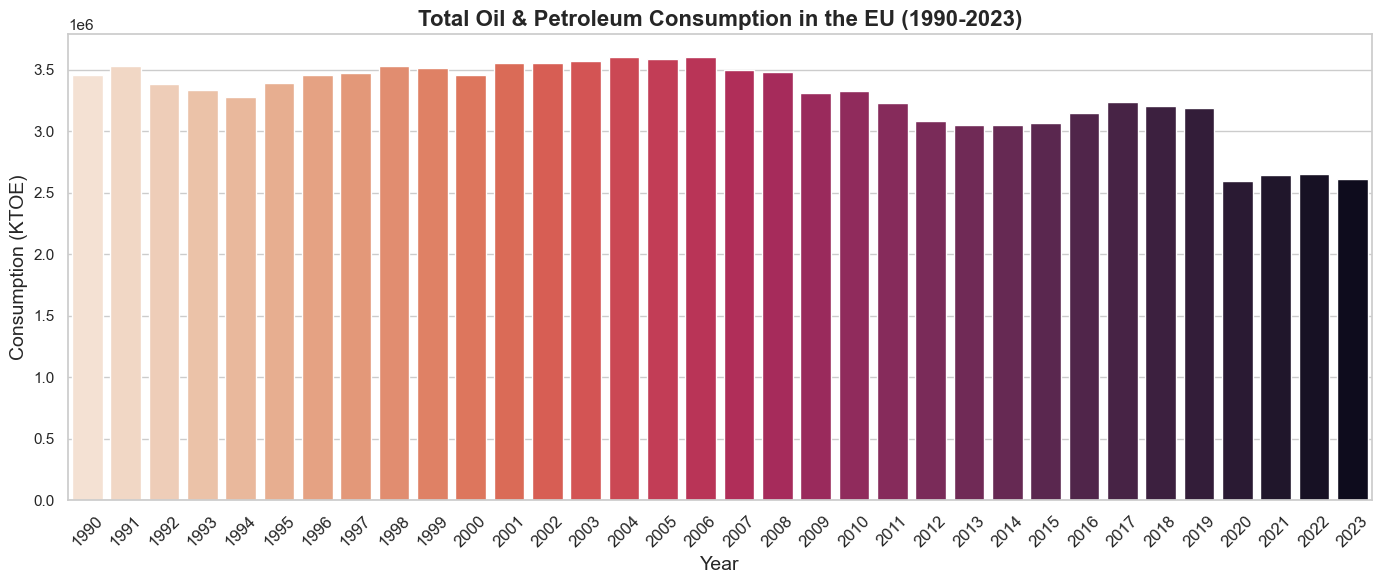

In [77]:
plot_total_consumption(oil_petrol_pivot, "Oil & Petroleum")

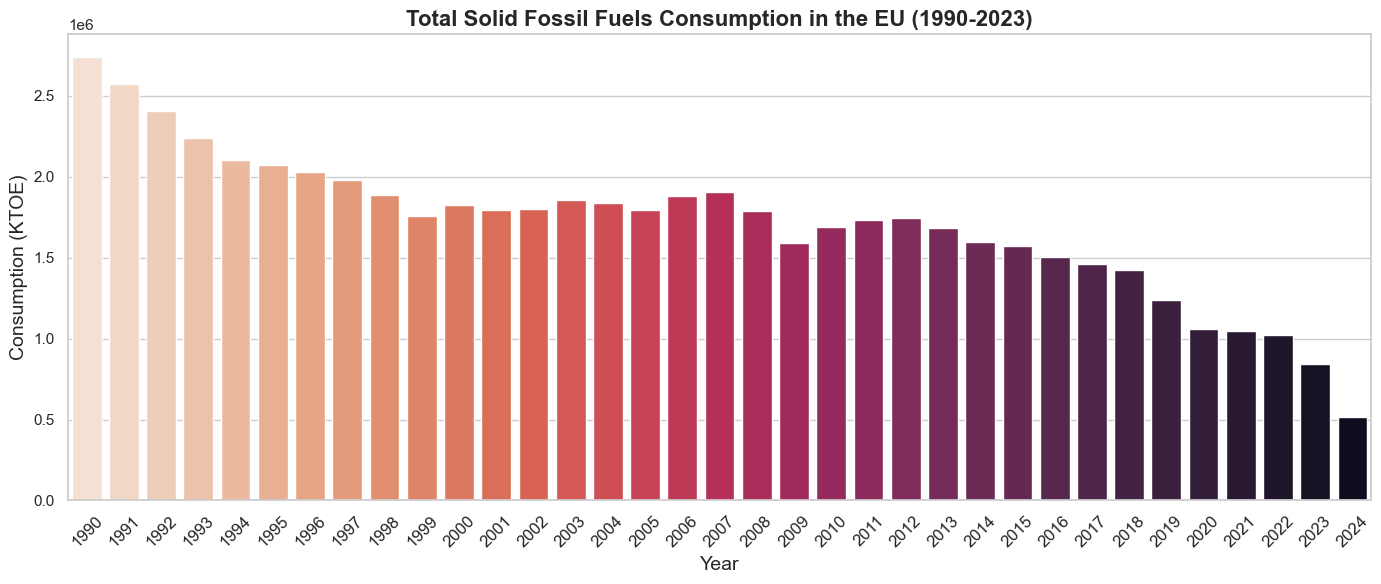

In [78]:
plot_total_consumption(solid_fossil_fuels_pivot, "Solid Fossil Fuels")

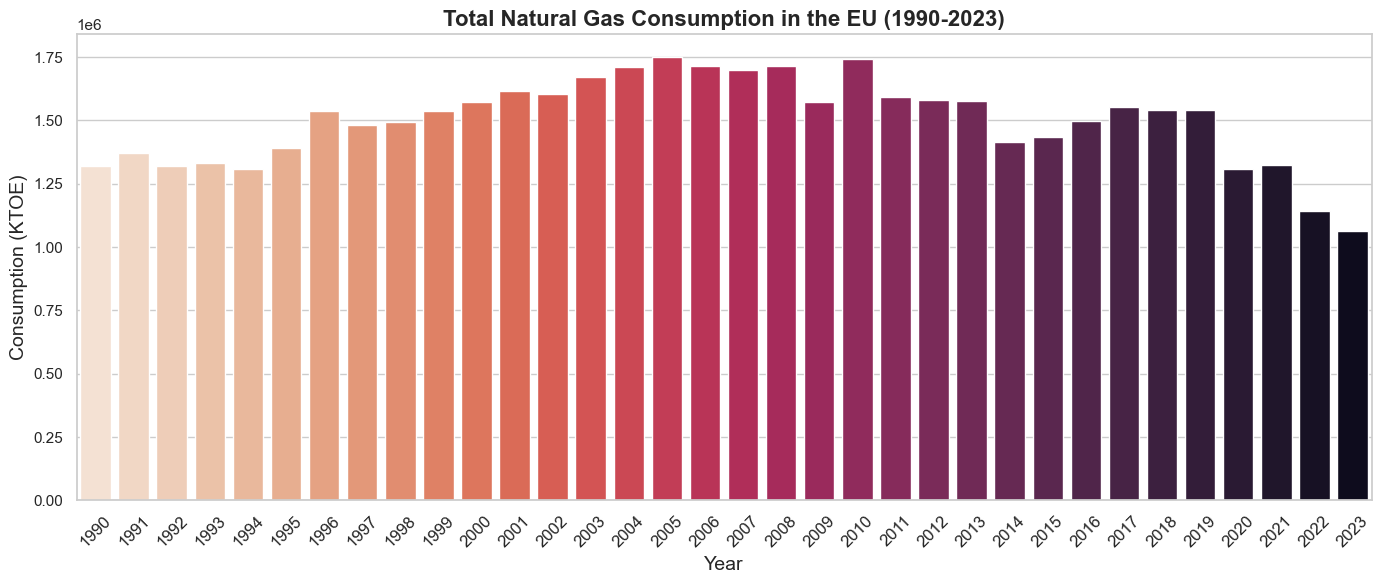

In [79]:
plot_total_consumption(natural_gas_pivot, "Natural Gas")

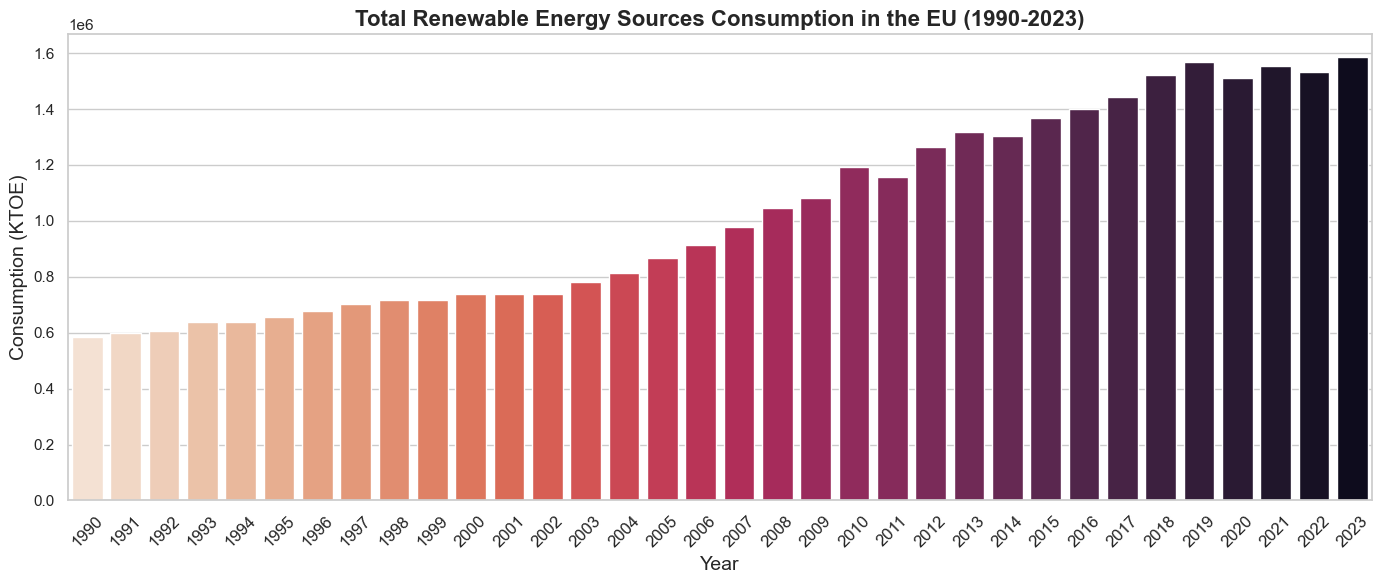

In [80]:
plot_total_consumption(renewables_pivot, "Renewable Energy Sources")

### 3.2 EU Energy Consumption Trends by Fuel Type (1990-2023)

A combined line plot and stacked area chart were created to visualise overall EU energy consumption trends by fuel type from 1990 to 2023. The combined visualisations provide insights into how the EU's energy mix has evolved, highlighting shifts from fossil fuels to renewables and changes in the relative importance of oil, gas, and solid fuels.

The visualisations were created using the cleaned and aggregated `all_energy` dataframe, which contains country-level annual consumption data for all fuel types. The data was grouped by year and fuel type to calculate total EU consumption for each category. 

In [29]:
# Prepare data for plotting
all_energy.head()

,Country,Year,Consumption_KTOE,fuel_type
0,Albania,1990,4884.643,Oil & Petroleum
1,Albania,1991,3349.616,Oil & Petroleum
2,Albania,1992,2540.534,Oil & Petroleum
3,Albania,1993,2469.427,Oil & Petroleum
4,Albania,1994,3099.698,Oil & Petroleum


The line plot was generated using seaborn's `lineplot()` function and illustrates year-on-year changes for each fuel type.

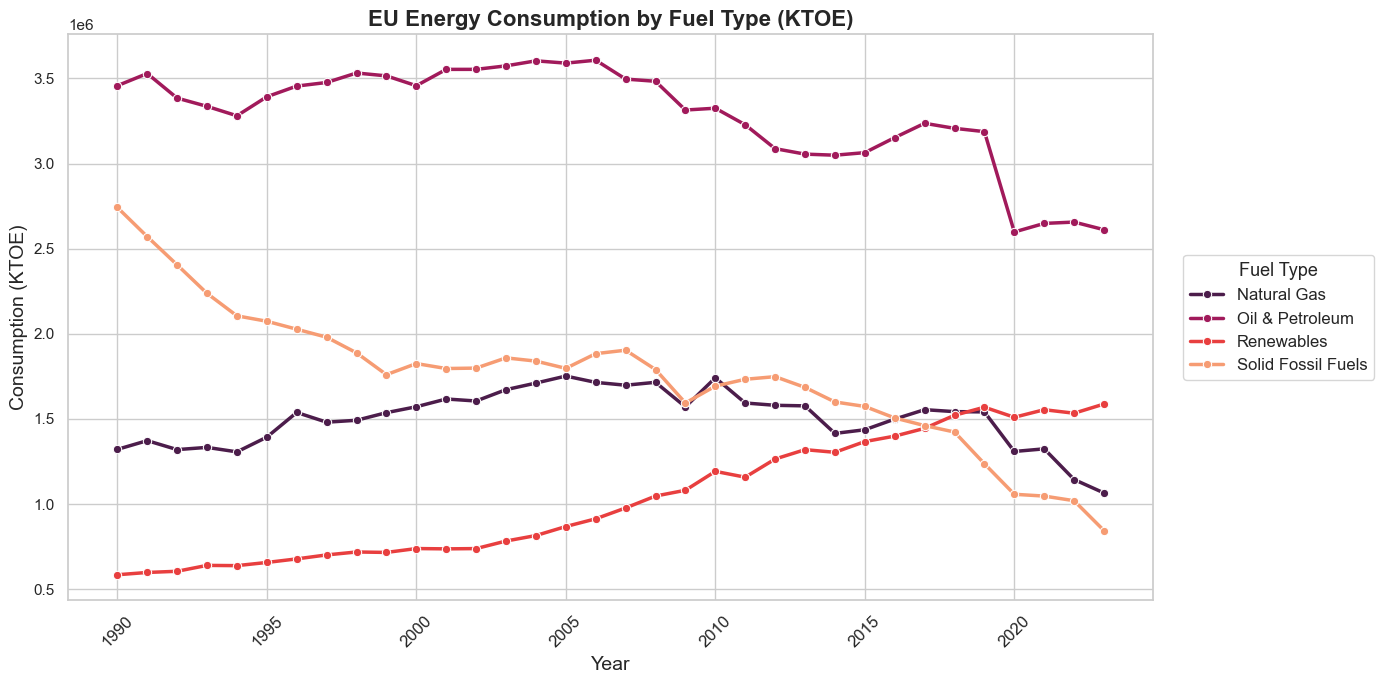

In [72]:
# Group by Year and fuel_type to get total EU consumption
eu_fuel_year = (
    all_energy[all_energy["Year"] < 2024]
    .groupby(['Year', 'fuel_type'], as_index=False)['Consumption_KTOE']
    .sum()
)
plt.figure(figsize=(14,7))

sns.lineplot(
    data=eu_fuel_year,
    x="Year",
    y="Consumption_KTOE",
    hue="fuel_type",
    linewidth=2.5,
    marker="o",
    palette="rocket",
)

plt.title("EU Energy Consumption by Fuel Type (KTOE)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Consumption (KTOE)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Fuel Type", fontsize=12, title_fontsize=13)
# Move legend outside the plot (right side)
plt.legend(
    title="Fuel Type",
    fontsize=12,
    title_fontsize=13,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout()
plt.show()


How has the EU energy mix changed over time?

To analyse structural changes in the EU energy system, fuel consumption was expressed as a percentage of total annual EU energy consumption. This allows comparison across fuels and over time, independently of changes in total demand.

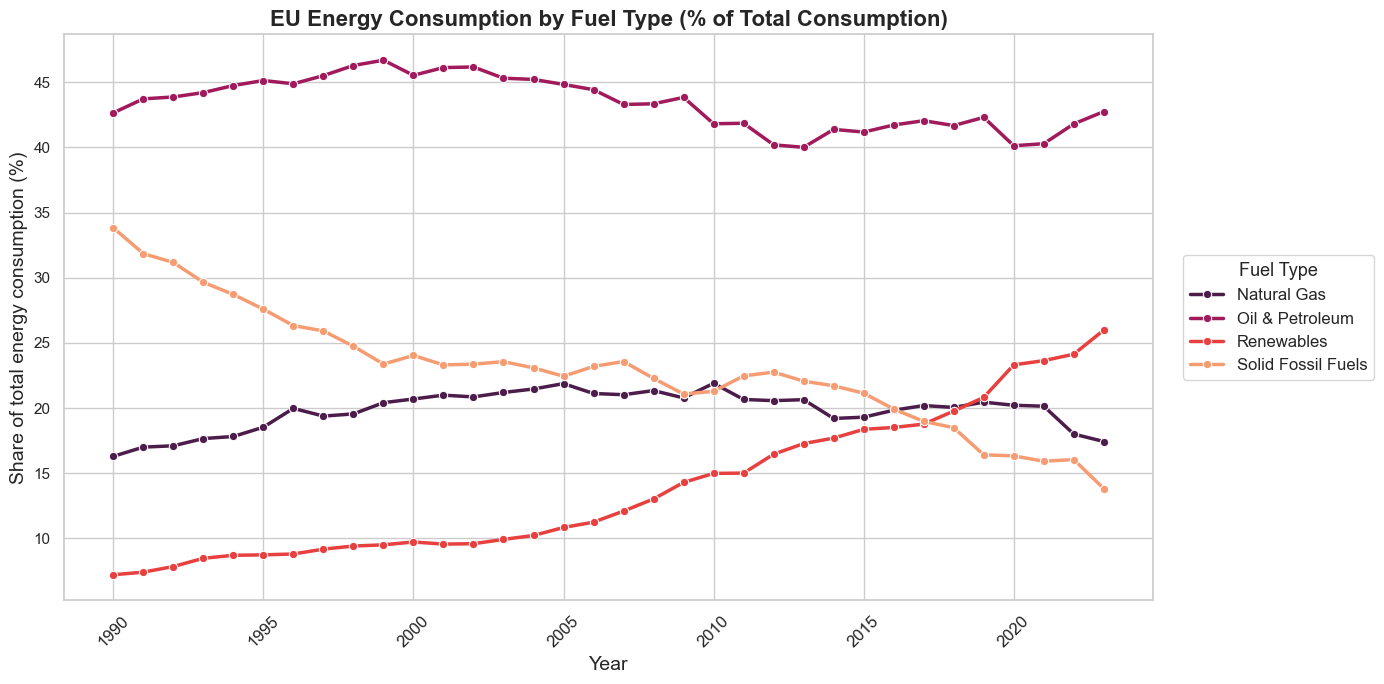

In [65]:
# 1. Total EU energy consumption per year
eu_total = (
    all_energy[all_energy["Year"] < 2024]
    .groupby("Year")["Consumption_KTOE"]
    .sum()
    .reset_index(name="Total_KTOE")
)

# 2. EU consumption per fuel type per year
eu_fuel_year = (
    all_energy[all_energy["Year"] < 2024]
    .groupby(["Year", "fuel_type"])["Consumption_KTOE"]
    .sum()
    .reset_index()
)

# 3. Merge totals and compute percentage share
eu_fuel_share = eu_fuel_year.merge(
    eu_total,
    on="Year",
    how="left"
)

eu_fuel_share["Share_percent"] = (
    eu_fuel_share["Consumption_KTOE"] / eu_fuel_share["Total_KTOE"] * 100
)

# 4. Line plot of fuel shares
plt.figure(figsize=(14,7))
sns.lineplot(
    data=eu_fuel_share,
    x="Year",
    y="Share_percent",
    hue="fuel_type",
    linewidth=2.5,
    marker="o",
    palette="rocket",
)

plt.title("EU Energy Consumption by Fuel Type (% of Total Consumption)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Share of total energy consumption (%)", fontsize=14)
plt.legend(title="Fuel Type", fontsize=12, title_fontsize=13)
plt.legend(
    title="Fuel Type",
    fontsize=12,
    title_fontsize=13,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)
plt.tight_layout()
plt.show()



In [32]:
def pct_change_absolute(df, fuel, start_year, end_year):
    total = (
        df[df["fuel_type"] == fuel]
        .groupby("Year")["Consumption_KTOE"]
        .sum()
    )

    return (
        (total.loc[end_year] - total.loc[start_year]) /
        total.loc[start_year] * 100
    )


In [33]:
pct_change_absolute(all_energy, "Oil & Petroleum", 2014, 2023)


-14.35285979302781

In [34]:
pct_change_absolute(all_energy, "Solid Fossil Fuels", 2014, 2023)


-47.22200754281366

In [35]:
pct_change_absolute(all_energy, "Natural Gas", 2014, 2023)

-24.72125810722943

In [36]:
pct_change_absolute(all_energy, "Renewables", 2014, 2023)

21.73630990604411

### 3.3 Geospatial Visualization of Fuel Consumption in the EU (2015-2023)

Spatial visualisation was performed using Natural Earth 1:110m boundaries, with country names harmonised and European geometries spatially constrained to avoid overseas territories.

In [37]:
# Load world shapefile
world = gpd.read_file(
    "ne_110m_admin_0_countries.shp"
)

In [38]:
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.067, 180 -16.555, 179...."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.904 -0.95, 34.073 -1.0598, 37.699..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.6656 27.656, -8.6651 27.589, -8.6..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97 49.003, -1..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.03 4..."


In [39]:
def check_country_mismatches(world_gdf, data_df, country_col="Country"):
    """
    Prints countries present in the energy data but missing from the map dataset.
    """
    map_countries = set(world_gdf["ADMIN"].unique())
    data_countries = set(data_df[country_col].unique())

    missing = data_countries - map_countries

    if missing:
        print("Countries not directly matched in map:")
        for c in missing:
            print(f"\nEnergy country: {c}")
            print(
                world_gdf[
                    world_gdf["ADMIN"].str.contains(c.split()[0], case=False, na=False)
                ]["ADMIN"].unique()
            )
    else:
        print("No country mismatches found.")


In [40]:
COUNTRY_NAME_MAP = {
    "Serbia": "Republic of Serbia",
    "Kosovo*": "Kosovo",
    "Türkiye": "Turkey"
}

In [41]:
def prepare_map_data(df, start_year=2015, end_year=2023):
    """
    Aggregates average fuel consumption per country for mapping.
    """
    map_data = (
        df.query("Year >= @start_year and Year <= @end_year")
          .groupby("Country", as_index=False)["Consumption_KTOE"]
          .mean()
    )

    map_data["Country_map"] = map_data["Country"].replace(COUNTRY_NAME_MAP)
    return map_data


In [42]:
def prepare_europe_map(world_gdf, countries):
    """
    Returns a clean Europe-only map without overseas territories.
    """

    # Explode multipolygons (removes French Guiana etc.)
    world_exploded = world_gdf.explode(index_parts=False)

    # Clip to Europe bounding box
    europe = world_exploded.cx[-25:45, 34:72]

    # Keep only countries in analysis
    europe = europe[europe["ADMIN"].isin(countries)]

    return europe


In [43]:
def build_geo_energy_map(world_gdf, fuel_df):
    """
    Full pipeline: prepare data, harmonise names, merge with map.
    """
    map_data = prepare_map_data(fuel_df)

    harmonised_countries = set(map_data["Country_map"].unique())
    europe_map = prepare_europe_map(world_gdf, harmonised_countries)

    geo_energy = europe_map.merge(
        map_data,
        left_on="ADMIN",
        right_on="Country_map",
        how="left"
    )

    return geo_energy


In [60]:
def plot_fuel_map(geo_df, fuel_name, cmap="rocket"):
    fig, ax = plt.subplots(figsize=(10, 8))

    geo_df.plot(
        column="Consumption_KTOE",
        cmap=cmap,
        linewidth=0.5,
        edgecolor="0.6",
        legend=True,
        ax=ax,
        missing_kwds={
            "color": "lightgrey",
            "label": "No data"
        }
    )

    ax.set_title(f"Average {fuel_name} Consumption (2015–2023)")
    ax.axis("off")

    plt.tight_layout()
    plt.show()


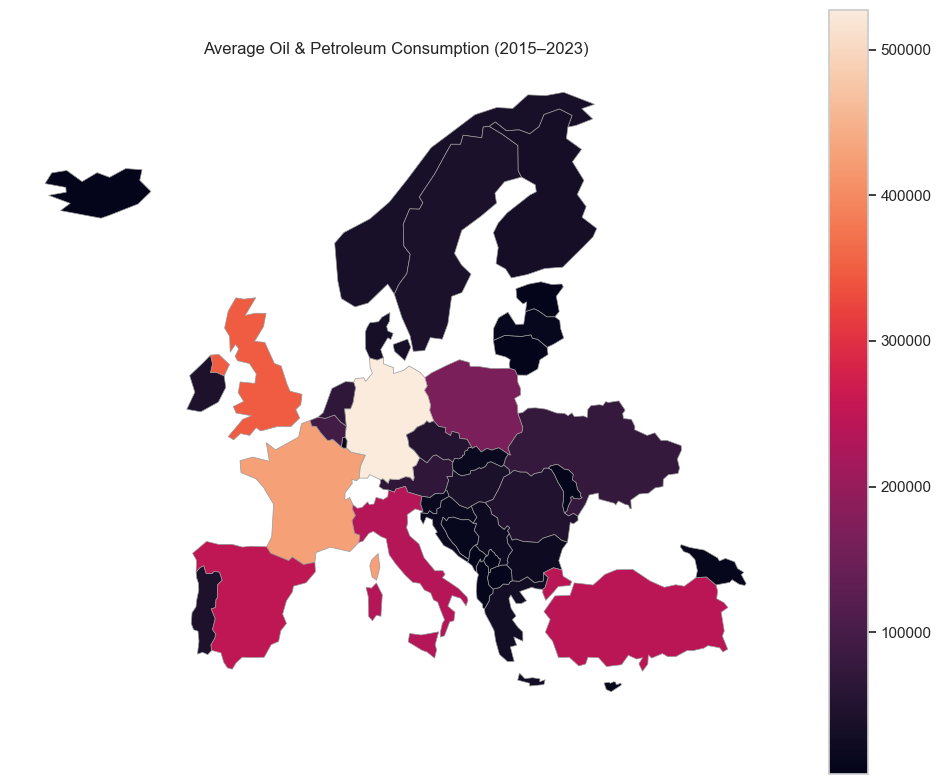

In [61]:
geo_oil = build_geo_energy_map(world, oil_petrol_clean)
plot_fuel_map(geo_oil, "Oil & Petroleum")


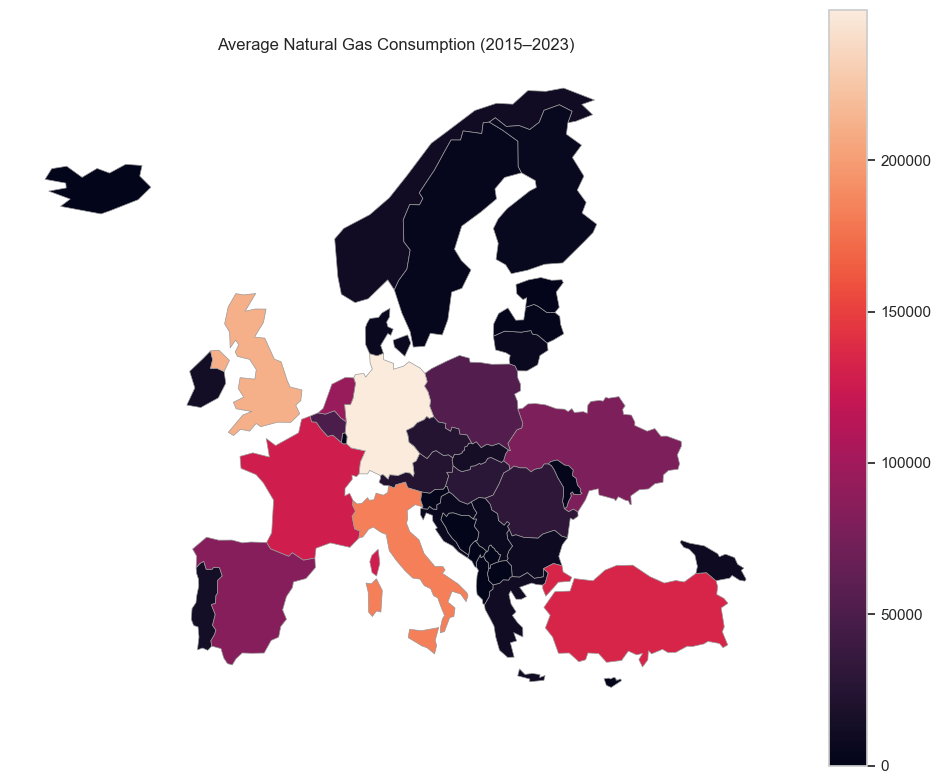

In [62]:

geo_gas = build_geo_energy_map(world, natural_gas_clean)
plot_fuel_map(geo_gas, "Natural Gas")



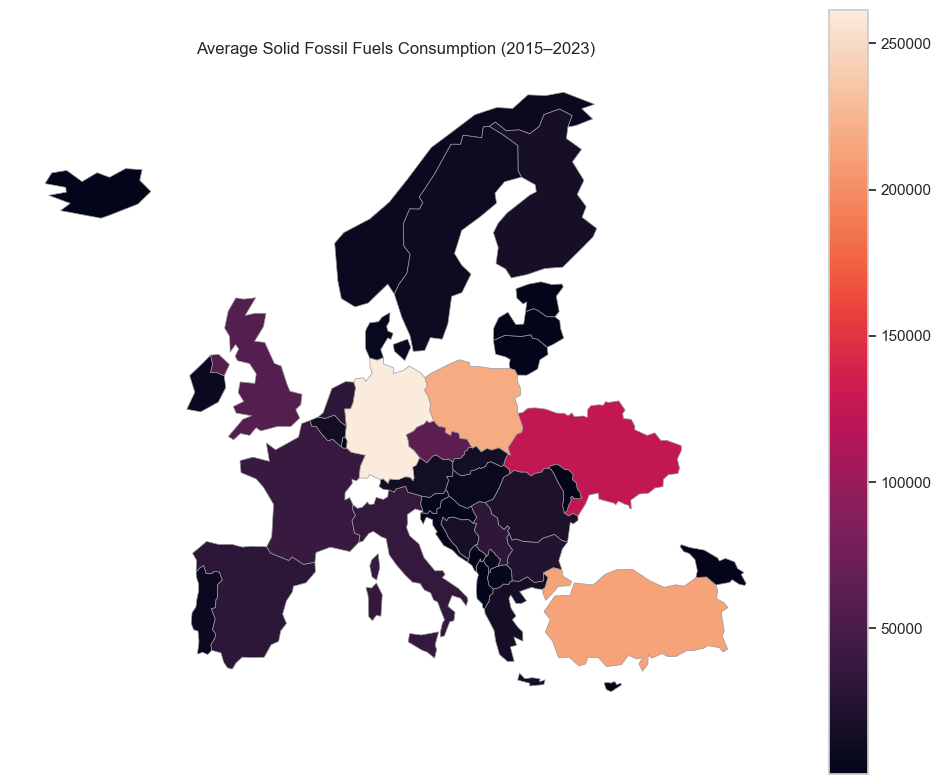

In [63]:

geo_solid = build_geo_energy_map(world, solid_fossil_fuels_clean)
plot_fuel_map(geo_solid, "Solid Fossil Fuels")


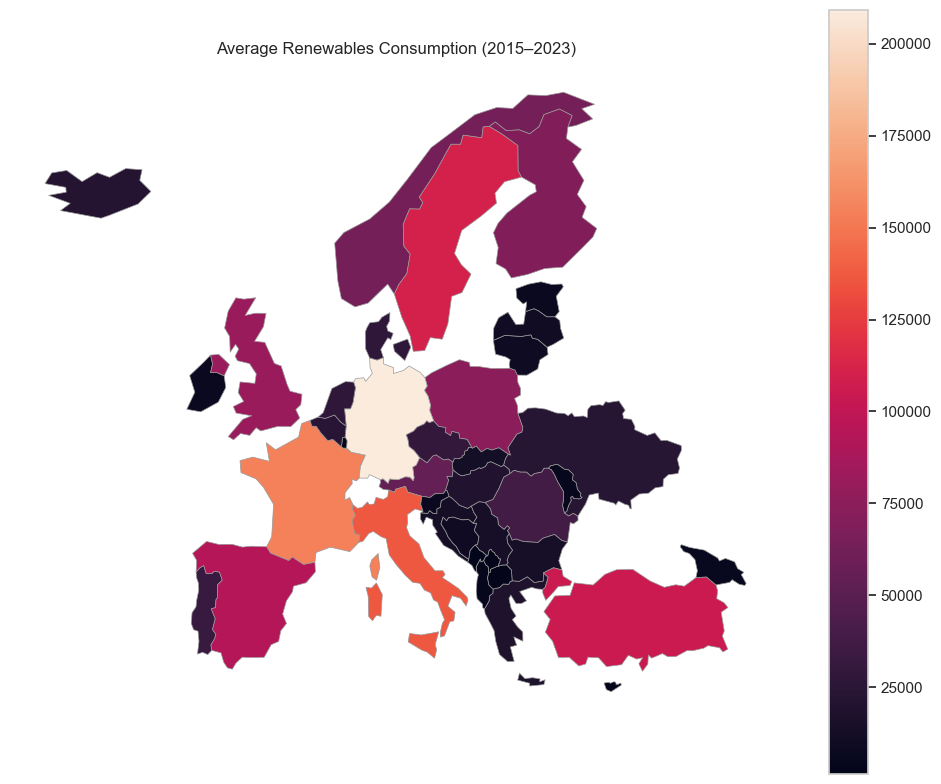

In [64]:

geo_renew = build_geo_energy_map(world, renewables_clean)
plot_fuel_map(geo_renew, "Renewables")

In [49]:
# Prepare data for mapping: average oil & petroleum consumption per country (2015-2023)
map_data = (
    oil_petrol_clean  # e.g. oil_petrol_clean
    .query("Year >= 2015 and Year <= 2023")
    .groupby("Country", as_index=False)["Consumption_KTOE"]
    .mean()
)


In [50]:
map_countries = set(world["ADMIN"].unique())
data_countries = set(map_data["Country"].unique())

missing_in_map = data_countries - map_countries

for c in missing_in_map:
    print(f"\nEnergy country: {c}")
    print(
        world[world["ADMIN"].str.contains(c.split()[0], case=False, na=False)]
        ["ADMIN"]
        .unique()
    )



Energy country: Türkiye
[]

Energy country: Serbia
['Republic of Serbia']

Energy country: Malta
[]

Energy country: Kosovo*
['Kosovo']


### 3.4 Country-Level Comparative Analysis (1990-2023)

Country-level comparisons are restricted to countries with sufficient data completeness, as defined in Section 2. Countries with more than 20% missing years were excluded from comparative visualisations to avoid biased comparisons. Heatmaps were created to visualise the top 10 energy consuming countries for each fuel type over time using the `top_10_heatmap()` function defined below.

In [66]:
def top_10_heatmap(pivot_df, fuel_name, threshold=0.2, top_n=10):
    """
    Plots a heatmap of the top N energy consuming countries for a given fuel type.
    Countries with more than a given fraction of missing data are excluded.
    Parameters:
    -----------
    pivot_df : pd.DataFrame
        Pivot table with countries as rows and years as columns
    fuel_name : str
        Name of the fuel type (used in plot title)
    ax : matplotlib.axes.Axes
        Axes object to plot the heatmap on
    threshold : float
        Fraction of missing years above which a country is excluded
    top_n : int
        Number of top consuming countries to display
    """
    # Identify countries with >20% missing data
    na_ratio = pivot_df.isna().mean(axis=1)
    excluded = na_ratio[na_ratio > threshold].index

    # Remove problematic countries
    clean_pivot = pivot_df.drop(index=excluded)

    # Select top N consumers
    top_countries = clean_pivot.sum(axis=1).nlargest(top_n).index
    heatmap_data = clean_pivot.loc[top_countries]

    # Plot heatmap
    plt.figure(figsize=(14,7))
    sns.heatmap(
        heatmap_data,
        cmap="rocket",
        linewidths=0.3,
        cbar=True,
        cbar_kws={"label": "Consumption (ktoe)"}
    )

    plt.title(f"Top 10 EU {fuel_name} Consumers", fontsize=13, weight="bold")
    plt.xlabel("Year", fontsize=11)
    plt.ylabel("Country", fontsize=11)
    plt.tick_params(axis="x", rotation=45, labelsize=9)
    plt.tick_params(axis="y", labelsize=9)



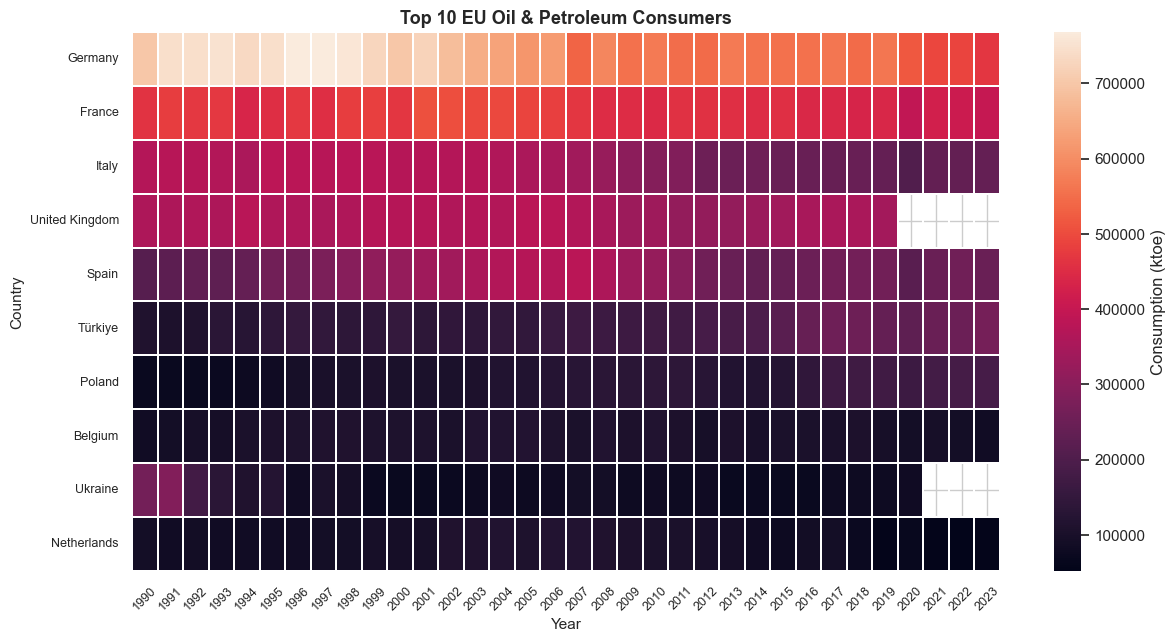

In [67]:
top_10_heatmap(oil_petrol_pivot, "Oil & Petroleum")

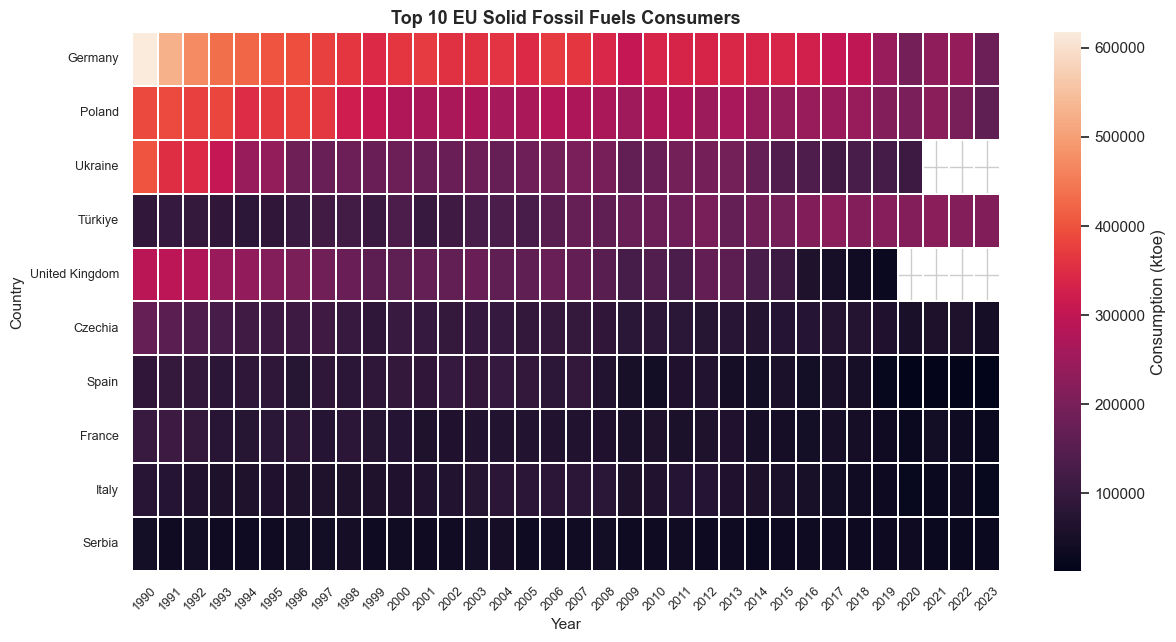

In [68]:
top_10_heatmap(solid_fossil_pivot, "Solid Fossil Fuels")

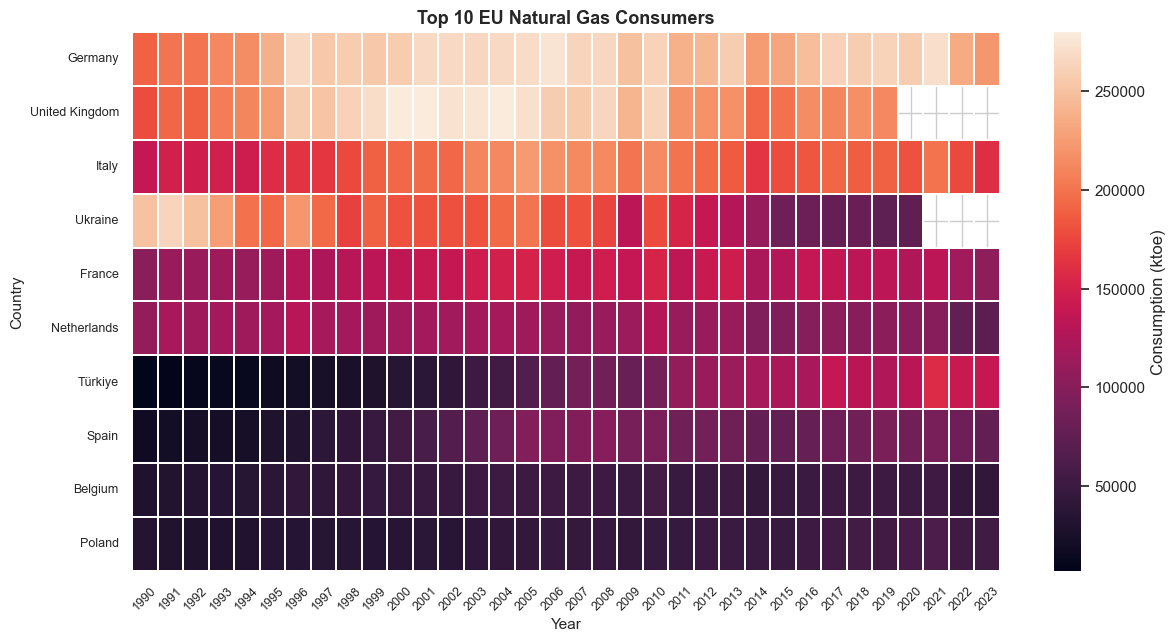

In [69]:
top_10_heatmap(natural_gas_pivot, "Natural Gas")

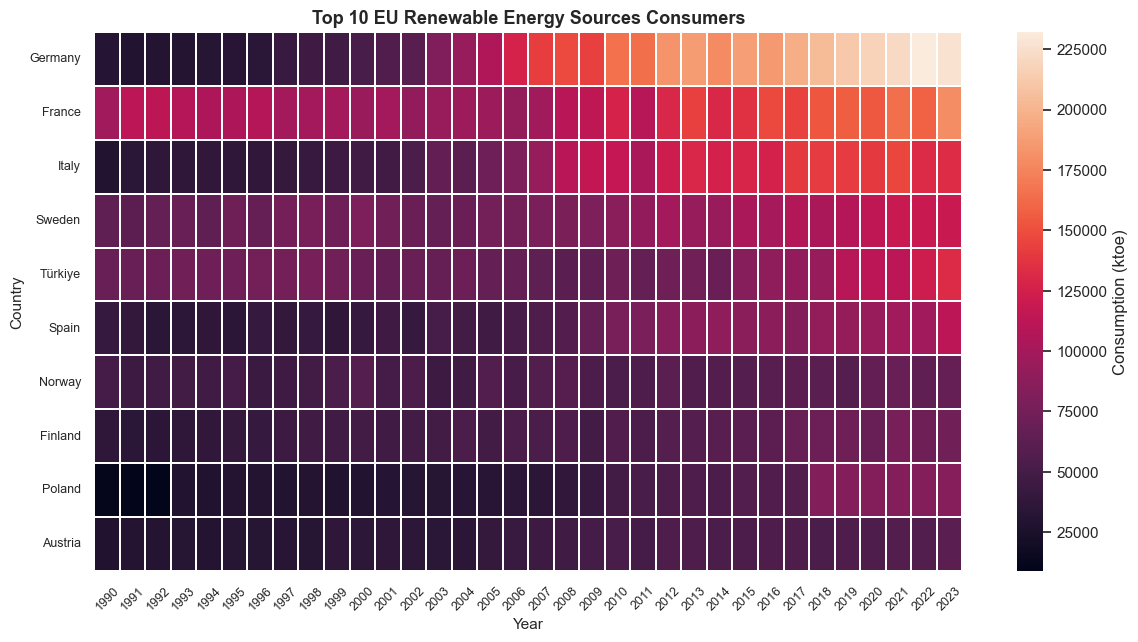

In [70]:
top_10_heatmap(renewables_pivot, "Renewable Energy Sources")

It is evident from the heatmaps that certain countries consistently rank among the top consumers across multiple fuel types, reflecting their larger economies and energy demands. For example, Germany, France, Italy, and Spain appear prominently in oil, gas, and renewables consumption. In contrast, some countries show high consumption in specific fuel types only, indicating differing energy profiles and resource availability.
It is important to note that UK data is included in the visualisations, as it was part of the Eurostat dataset for the entire study period (1990-2023), despite Brexit occurring in 2020. Some data for the UK is missing post-2020, but enough data points exist to include it in the analysis. Ukraine is also missing data for several years due to political reasons, but its inclusion is important given its significant energy consumption profile in Europe. These inclusions allow for a complete historical analysis of energy consumption trends across Europe.

### 3.5 Energy Consumption by Fuel Type in Ireland (1990-2023)

This section focuses on a country-level analysis of energy consumption in Ireland, disaggregated by fuel type and measured in kilotonnes of oil equivalent (KTOE) over the period 1990–2023. While previous sections examined aggregate EU trends, this analysis provides a more detailed national perspective, allowing for the identification of country-specific patterns and transitions in the energy mix.

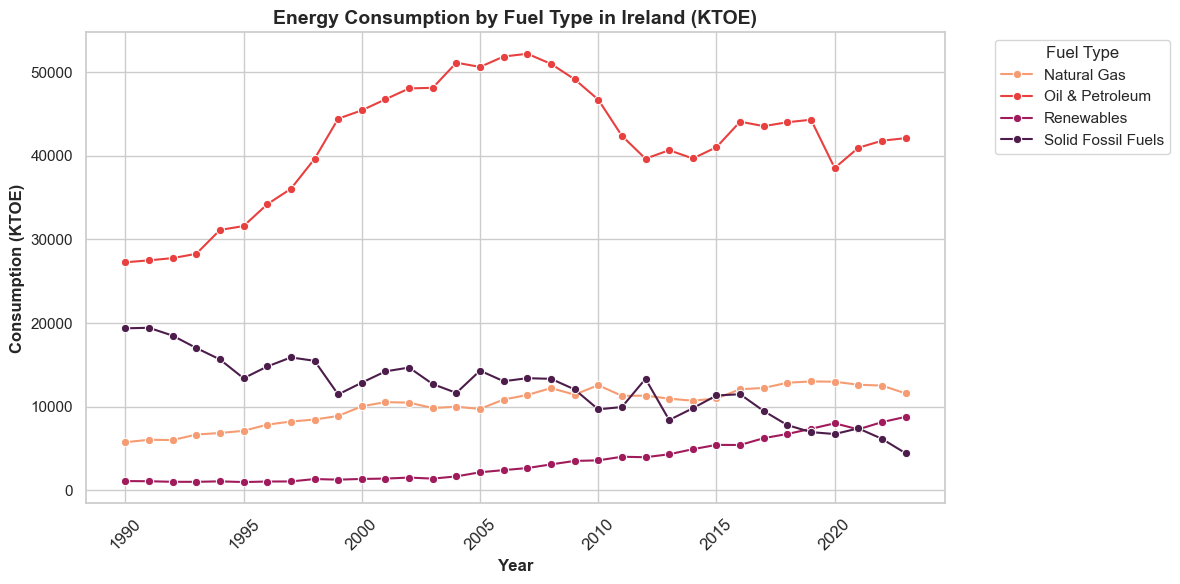

In [81]:
# Filter data for Ireland and exclude 2024
ireland_energy = all_energy[
    (all_energy["Country"] == "Ireland") &
    (all_energy["Year"] <= 2023)
]

# Group by Year and fuel type
ireland_fuel_year = (
    ireland_energy
    .groupby(["Year", "fuel_type"], as_index=False)["Consumption_KTOE"]
    .sum()
)

# Line plot
plt.figure(figsize=(12,6))

sns.lineplot(
    data=ireland_fuel_year,
    x="Year",
    y="Consumption_KTOE",
    hue="fuel_type",
    marker="o",
    palette="rocket_r",
)
plt.title("Energy Consumption by Fuel Type in Ireland (KTOE)", fontsize=14, fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Consumption (KTOE)", fontsize=12, fontweight="bold")
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
